# Predicting Speed of News Dissemination using Machine Learning Algorithm

#### *LT6*

In [10]:
import pandas as pd
# import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import time
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score

In [3]:
from dask.distributed import Client
client = Client()

In [4]:
client

Client Scheduler: tcp://127.0.0.1:43263 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 134.01 GB


## Reading the working dataset

In [5]:
df = pd.read_parquet('s3://bdcc-lab/df_merged.parquet')

In [6]:
df.head()

,GlobalEventID,EventTimeDate,MentionTimeDate,MentionType,SentenceID,Actor1CharOffset,Actor2CharOffset,ActionCharOffset,MentionDocLen,MentionDocTone,...,EventCode,EventBaseCode,EventRootCode,QuadClass,NumMentions,NumSources,NumArticles,AvgTone,mention_source,mention_article
0,813443217,20190101040000,20190101081500,1,6,1546,-1,1527,2227,3.07692307692307,...,043,043,04,1,10,1,10,-0.89514066496163,10.0,1.0
1,813443217,20190101040000,20190101040000,1,9,-1,3858,3844,4858,-0.89514066496163,...,043,043,04,1,10,1,10,-0.89514066496163,10.0,1.0
2,813443217,20190101040000,20190101080000,1,6,1546,-1,1527,2224,3.07692307692307,...,043,043,04,1,10,1,10,-0.89514066496163,10.0,1.0
3,813449194,20190101053000,20190101053000,1,8,2553,-1,2587,7011,0.55658627087198,...,070,070,07,2,10,1,10,0.55658627087198,10.0,1.0
4,813494031,20190101143000,20190101143000,1,14,-1,3746,3738,4024,-2.42057488653555,...,020,020,02,1,10,1,10,-2.42057488653555,10.0,1.0


In [7]:
df.shape

(44069, 40)

### Data Preprocessing

In [8]:
list_cols = ['GlobalEventID',
             'MentionTimeDate',
             "EventTimeDate",
             'MentionType',
             'SentenceID',
             'Actor1CharOffset',
             'Actor2CharOffset',
             'ActionCharOffset',
             'MentionDocLen',
             'MentionDocTone',
             'Day',
             'NumMentions',
             'NumSources',
             'NumArticles',
             'AvgTone',
             'mention_source',
             'mention_article']

for i in list_cols:
    df[i] = df[i].astype(float)

In [9]:
df['tone_diff'] = df['MentionDocTone'].astype(float) - df['AvgTone'].astype(float)

In [10]:
df['MentionTimeDate'] = df['MentionTimeDate'].apply(lambda x: pd.to_datetime(str(int(x)), format='%Y%m%d%H%M%S'))
df['EventTimeDate'] = df['EventTimeDate'].apply(lambda x: pd.to_datetime(str(int(x)), format='%Y%m%d%H%M%S'))

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:37446 remote=tcp://127.0.0.1:43263>


In [11]:
df['min_diff'] = df['MentionTimeDate'] - df['EventTimeDate']

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:37448 remote=tcp://127.0.0.1:43263>


In [12]:
df['min_diff'] = df['min_diff'].dt.seconds / 60

In [13]:
df['mention_day'] = df['MentionTimeDate'].astype(str).map(lambda x: x[:-8])

In [15]:
df.isnull().sum()

GlobalEventID               0
EventTimeDate               0
MentionTimeDate             0
MentionType                 0
SentenceID                  0
Actor1CharOffset            0
Actor2CharOffset            0
ActionCharOffset            0
MentionDocLen               0
MentionDocTone              0
Day                         0
Actor1Code               5244
Actor1CountryCode       27066
Actor1KnownGroupCode    43549
Actor1EthnicCode        43911
Actor1Religion1Code     42504
Actor1Religion2Code     43752
Actor1type1Code         20629
Actor1type2Code         42659
Actor1type3Code         44035
Actor2Code              16620
Actor2CountryCode       32768
Actor2KnownGroupCode    43524
Actor2EthnicCode        43955
Actor2Religion1Code     41575
Actor2Religion2Code     42561
Actor2type1Code         28437
Actor2type2Code         43012
Actor2type3Code         44058
IsRootEvent                 0
EventCode                   0
EventBaseCode               0
EventRootCode               0
QuadClass 

### Feature Engineering

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(lowercase=False, tokenizer=lambda x: x)

types1 = df.filter(regex=".*1type.*").fillna('').apply(list,axis=1)
types2 = df.filter(regex=".*2type.*").fillna('').apply(list,axis=1)

df_type1 = pd.DataFrame(vec.fit_transform(types1).todense(), columns=["Actor1_" + i for i in vec.get_feature_names()]).iloc[:, 1:]
df_type2 = pd.DataFrame(vec.fit_transform(types2).todense(), columns=["Actor2_" + i for i in vec.get_feature_names()]).iloc[:, 1:]

In [17]:
df[df_type1.columns] = df_type1
df[df_type2.columns] = df_type2

In [18]:
df['actor1_ethnic'] = df['Actor1EthnicCode'].isnull()
df['actor1_ethnic'] = df['actor1_ethnic'].apply(lambda x: 1 if x == 'False' else 0)

df['actor2_ethnic'] = df['Actor2EthnicCode'].isnull()
df['actor2_ethnic'] = df['actor2_ethnic'].apply(lambda x: 1 if x == 'False' else 0)

df['Actor1_Religion'] = df['Actor1Religion1Code'].isnull()
df['Actor1_Religion'] = df['Actor1_Religion'].apply(lambda x: 1 if x == 'False' else 0)

df['Actor2_Religion'] = df['Actor2Religion1Code'].isnull()
df['Actor2_Religion'] = df['Actor2_Religion'].apply(lambda x: 1 if x == 'False' else 0)

In [19]:
df = df.set_index('GlobalEventID')

In [21]:
import pycountry_convert as pc
from pycountry_convert import country_alpha3_to_country_alpha2
from pycountry_convert.convert_country_alpha2_to_continent_code import country_alpha2_to_continent_code

In [22]:
def continent(code):
    manual_dict = {'SEA':"Asia", "EUR":"Europe", 'TMP': 'Asia', 'VA': 'Europe',
                  'AFR':'Africa', 'ASA':'South America', 'WST':'Oceania', 'SAS':'South America'}
    if code == "PHL":
        return "Philippines"
    try:
        code = pc.country_alpha3_to_country_alpha2(code)
        code = pc.country_alpha2_to_continent_code(code)
        country_continent_name = pc.convert_continent_code_to_continent_name(code)
    except KeyError:
        country_continent_name = manual_dict[code]
    return country_continent_name

In [23]:
df['Actor1_cc'] = df['Actor1CountryCode'].apply(lambda x: continent(x) if x else x)

In [24]:
df['Actor2_cc'] = df['Actor2CountryCode'].apply(lambda x: continent(x) if x else x)

In [25]:
df_get_dum = pd.get_dummies(df, columns=['Actor1KnownGroupCode', 'Actor2KnownGroupCode'])

In [26]:
to_drop = ['MentionTimeDate', 'EventTimeDate', 'MentionType', 
            'mention_day',
            'Actor1Code',
             'Actor1CountryCode',
             'Actor1EthnicCode',
             'Actor1Religion1Code',
             'Actor1Religion2Code',
             'Actor1type1Code',
             'Actor1type2Code',
             'Actor1type3Code',
             'Actor2Code',
             'Actor2CountryCode',
             'Actor2EthnicCode',
             'Actor2Religion1Code',
             'Actor2Religion2Code',
             'Actor2type1Code',
             'Actor2type2Code',
             'Actor2type3Code',
            'EventCode',
             'EventBaseCode',
           'Day'
            ]
df_get_dum = df_get_dum.drop(columns=to_drop, errors='ignore')

In [27]:
df_final = pd.get_dummies(df_get_dum)

In [28]:
df_final.head()

,SentenceID,Actor1CharOffset,Actor2CharOffset,ActionCharOffset,MentionDocLen,MentionDocTone,NumMentions,NumSources,NumArticles,AvgTone,...,Actor1_cc_Oceania,Actor1_cc_Philippines,Actor1_cc_South America,Actor2_cc_Africa,Actor2_cc_Asia,Actor2_cc_Europe,Actor2_cc_North America,Actor2_cc_Oceania,Actor2_cc_Philippines,Actor2_cc_South America
GlobalEventID,,,,,,,,,,,,,,,,,,,,,
813443217.0,6.0,1546.0,-1.0,1527.0,2227.0,3.076923,10.0,1.0,10.0,-0.895141,...,0,0,0,0,0,0,0,0,1,0
813443217.0,9.0,-1.0,3858.0,3844.0,4858.0,-0.895141,10.0,1.0,10.0,-0.895141,...,0,0,0,0,0,0,0,0,1,0
813443217.0,6.0,1546.0,-1.0,1527.0,2224.0,3.076923,10.0,1.0,10.0,-0.895141,...,0,0,0,0,0,0,0,0,1,0
813449194.0,8.0,2553.0,-1.0,2587.0,7011.0,0.556586,10.0,1.0,10.0,0.556586,...,0,0,0,0,0,0,0,0,0,0
813494031.0,14.0,-1.0,3746.0,3738.0,4024.0,-2.420575,10.0,1.0,10.0,-2.420575,...,0,0,0,0,0,0,0,0,0,0


## EDA

In [44]:
df['MentionTimeDate'].value_counts()

2.019013e+13    128
2.019013e+13    121
2.019013e+13    110
2.019013e+13    109
2.019021e+13    101
               ... 
2.019031e+13      1
2.019032e+13      1
2.019030e+13      1
2.019012e+13      1
2.019011e+13      1
Name: MentionTimeDate, Length: 7760, dtype: int64

In [45]:
df['Day'].value_counts()

20190127.0    4012
20190213.0    1616
20190128.0    1318
20190221.0     792
20190214.0     766
              ... 
20180310.0       1
20180322.0       1
20180328.0       1
20180222.0       1
20180412.0       1
Name: Day, Length: 205, dtype: int64

In [46]:
df['MentionType'].value_counts()

1.0    44069
Name: MentionType, dtype: int64

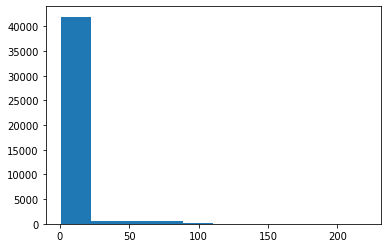

In [47]:
plt.hist(df['SentenceID']);

In [48]:
df['SentenceID'].value_counts()

1.0      7355
2.0      5875
3.0      4833
4.0      3830
7.0      2921
         ... 
202.0       1
119.0       1
220.0       1
136.0       1
219.0       1
Name: SentenceID, Length: 121, dtype: int64

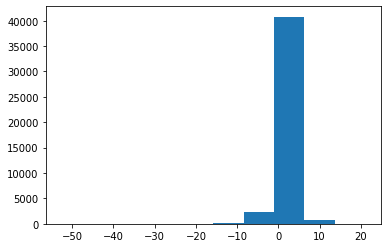

In [49]:
plt.hist(df['tone_diff']);

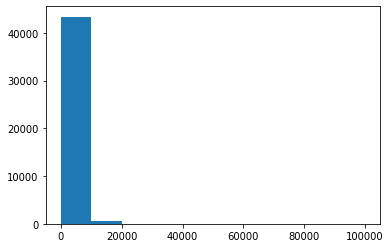

In [33]:
plt.hist(df['day_diff']);

In [34]:
df['day_diff'].value_counts()

0.0        42935
10000.0      678
7.0          154
1.0          122
99.0          68
102.0         35
8899.0        21
76.0          20
79.0          18
8876.0        11
70.0           4
99998.0        2
73.0           1
Name: day_diff, dtype: int64

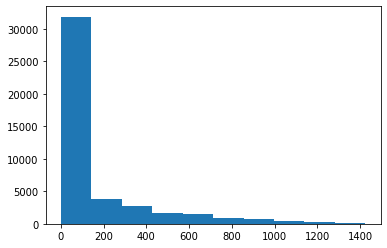

In [346]:
plt.hist(df['min_diff']);

In [347]:
df['min_diff'].value_counts()

0.0       25838
15.0       1114
30.0        873
45.0        766
60.0        690
          ...  
1380.0       12
1365.0       10
1350.0       10
1410.0        7
1425.0        2
Name: min_diff, Length: 96, dtype: int64

In [51]:
df.groupby('QuadClass')['GlobalEventID'].count()

QuadClass
1    25002
2     4830
3     7100
4     7137
Name: GlobalEventID, dtype: int64

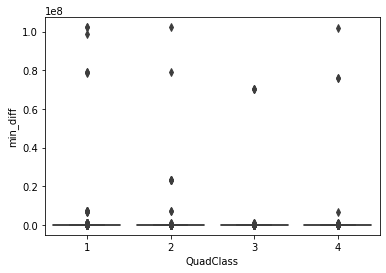

In [348]:
sns.boxplot(x='QuadClass', y='min_diff', data=df_dropped)

In [60]:
df['Actor1type1Code'].unique()

array([None, 'BUS', 'IMG', 'GOV', 'CVL', 'MIL', 'LEG', 'NGO', 'MED',
       'JUD', 'SPY', 'CRM', 'HLH', 'COP', 'IGO', 'EDU', 'LAB', 'AGR',
       'OPP', 'INS', 'REB', 'UAF', 'MNC', 'SEP', 'UIS', 'ELI', 'REF',
       'RAD', 'HRI', 'INT', 'ENV', 'SET'], dtype=object)

In [40]:
df_final.to_parquet('s3://bdcc-lab/df_final.parquet')

## Setting up X and y

In [3]:
X = df_final.drop(columns=['min_diff'])
y = df_final['min_diff']

In [4]:
cols = X.columns

In [5]:
# from regression_ria import regression
from sklearn.model_selection import train_test_split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [363]:
#No Scale
model1_noscale = regression(X_train, X_test, y_train, y_test, cols, scaler='None')
model1_noscale

Training KNN


/home/jbuno/.local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Training KNN complete in 22.950253009796143 seconds 

Training Linear Regression
Training Linear Regression complete in 2.1495330333709717 seconds 

Training Linear SVM


/home/jbuno/.local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training Linear SVM complete in 36.04036855697632 seconds 

Training Decision Tree
Training Decision Tree complete in 5.39584755897522 seconds 

Training Random Forest


/home/jbuno/.local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training Random Forest complete in 19.93030285835266 seconds 

Training Gradient Boost
Training Gradient Boost complete in 687.8933086395264 seconds 



,Test Accuracy,Train Accuracy,Best Parameters,Run Time,0,1,2
KNN,0.274568,0.346445,{'n_neighbors': 18},22.950253,[nan],[nan],[nan]
Linear Regression,0.308882,0.293509,{},2.149533,"(mention_article, -160.82762178169762)","(Actor1KnownGroupCode_WTO, 180.00211901377668)","(Actor1KnownGroupCode_ADB, 205.95240565403984)"
Linear SVM,-0.180616,-0.191970,{'tol': 1e-05},36.040369,"(EventRootCode_05, 35.453709327243374)","(NumSources, 38.61501280255585)","(IsRootEvent_0, 39.56197190222384)"
Decision Tree,0.614025,0.693964,{'max_depth': 9},5.395848,"(SentenceID, 0.06152771297783498)","(MentionDocLen, 0.06217580691685398)","(tone_diff, 0.6474390502703469)"
Random Forest,0.694756,0.847753,{'max_depth': 14},19.930303,"(SentenceID, 0.06152771297783498)","(MentionDocLen, 0.06217580691685398)","(tone_diff, 0.6474390502703469)"
Gradient Boost,0.719004,0.934718,{'max_depth': 11},687.893309,"(SentenceID, 0.06152771297783498)","(MentionDocLen, 0.06217580691685398)","(tone_diff, 0.6474390502703469)"


## With Scaling

In [364]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [365]:
mm=MinMaxScaler()
ss = StandardScaler()

In [366]:
model1_ss = regression(X_train, X_test, y_train, y_test, cols, scaler='ss')
model1_ss

Training KNN
Training KNN complete in 570.2675330638885 seconds 

Training Linear Regression
Training Linear Regression complete in 2.4082257747650146 seconds 

Training Linear SVM
Training Linear SVM complete in 19.353331089019775 seconds 

Training Decision Tree
Training Decision Tree complete in 8.501014709472656 seconds 

Training Random Forest


/home/jbuno/.local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training Random Forest complete in 31.434056043624878 seconds 

Training Gradient Boost


/home/jbuno/.local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Training Gradient Boost complete in 1250.0616290569305 seconds 



,Test Accuracy,Train Accuracy,Best Parameters,Run Time,0,1,2
KNN,5.029543e-01,0.619186,{'n_neighbors': 7},570.267533,[nan],[nan],[nan]
Linear Regression,-2.222094e+20,0.293498,{},2.408226,"(Actor1_Religion, -481716879845749.3)","(EventRootCode_04, 481860371493104.94)","(QuadClass_3, 599949624479754.0)"
Linear SVM,1.205777e-01,0.107567,{'tol': 0.021544346900318846},19.353331,"(ActionCharOffset, -73.8901609632675)","(NumSources, 79.45781739166748)","(NumArticles, -117.40894243959383)"
Decision Tree,6.140247e-01,0.693964,{'max_depth': 9},8.501015,"(SentenceID, 0.06152771297783498)","(MentionDocLen, 0.06217580691685398)","(tone_diff, 0.6474390502703469)"
Random Forest,6.947118e-01,0.847756,{'max_depth': 14},31.434056,"(SentenceID, 0.06152771297783498)","(MentionDocLen, 0.06217580691685398)","(tone_diff, 0.6474390502703469)"
Gradient Boost,7.187324e-01,0.934718,{'max_depth': 11},1250.061629,"(SentenceID, 0.06152771297783498)","(MentionDocLen, 0.06217580691685398)","(tone_diff, 0.6474390502703469)"


In [367]:
model1_mm = regression(X_train, X_test, y_train, y_test, cols, scaler='mm')
model1_mm

Training KNN
Training KNN complete in 759.0364849567413 seconds 

Training Linear Regression
Training Linear Regression complete in 2.419456958770752 seconds 

Training Linear SVM
Training Linear SVM complete in 3.5382394790649414 seconds 

Training Decision Tree
Training Decision Tree complete in 8.53028917312622 seconds 

Training Random Forest


/home/jbuno/.local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training Random Forest complete in 31.62661600112915 seconds 

Training Gradient Boost


/home/jbuno/.local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Training Gradient Boost complete in 1222.7480027675629 seconds 



,Test Accuracy,Train Accuracy,Best Parameters,Run Time,0,1,2
KNN,4.804588e-01,0.605240,{'n_neighbors': 7},759.036485,[nan],[nan],[nan]
Linear Regression,-4.028656e+10,0.293505,{},2.419457,"(MentionDocTone, 125539178183705.66)","(QuadClass_4, -130680061878684.56)","(QuadClass_1, -168142130033265.06)"
Linear SVM,-2.145293e-02,-0.030540,{'tol': 3.593813663804626},3.538239,"(SentenceID, 131.917310082157)","(mention_source, -175.77642637834603)","(NumSources, 192.2203646440512)"
Decision Tree,6.140247e-01,0.693964,{'max_depth': 9},8.530289,"(SentenceID, 0.06152771297783498)","(MentionDocLen, 0.06217580691685398)","(tone_diff, 0.6474390502703469)"
Random Forest,6.941800e-01,0.847868,{'max_depth': 14},31.626616,"(SentenceID, 0.06152771297783498)","(MentionDocLen, 0.06217580691685398)","(tone_diff, 0.6474390502703469)"
Gradient Boost,7.203185e-01,0.915262,{'max_depth': 10},1222.748003,"(SentenceID, 0.06152771297783498)","(MentionDocLen, 0.06217580691685398)","(tone_diff, 0.6474390502703469)"


In [355]:
def regression(X_train, X_val, y_train, y_val, cols, scaler=None):
    kneighbors = range(1, 20)
    a = np.logspace(-5, 5, num=10)
    gamma_list = np.logspace(-5, 5, num=10)
    depth_settings = range(1, 15)
    tolerance = np.logspace(-5, 5, num=10)
    
#     knn = KNeighborsRegressor(n_jobs=1)
#     lin_reg = LinearRegression()
#     lasso = Lasso(alpha=a)
#     ridge = Ridge(alpha=a)
#     lin_svm = LinearSVR(random_state=0, tol=tolerance)
#     nsvm_poly = SVR(kernel='poly', degree=3)
    d_tree = DecisionTreeRegressor(random_state=0, max_depth=depth_settings)
    r_forest = RandomForestRegressor(max_depth=depth_settings, random_state=0)
#     g_boost = GradientBoostingRegressor(random_state=0, max_depth=depth_settings, learning_rate=0.1)
    
    est = [
#         ('KNN',knn,{'n_neighbors':kneighbors}),
#        ('Linear Regression',lin_reg,{}),
#       ('Linear SVM',lin_svm,{'tol':tolerance}),
      ('Decision Tree',d_tree,{'max_depth':depth_settings}),
      ('Random Forest',r_forest,{'max_depth':depth_settings}),
#       ('Gradient Boost',g_boost,{'max_depth':depth_settings}),
    ]
    
#     X_train, X_val, y_train, y_val = train_test_split(X, y,random_state=1)
    
    if scaler == 'ss':
        scale = StandardScaler()
        X_train = scale.fit_transform(X = X_train)
        X_val = scale.transform(X = X_val)
    elif scaler == 'mm':
        scale = MinMaxScaler()
        X_train = scale.fit_transform(X_train)
        X_val = scale.transform(X_val)
    else:
        pass
    
    models = {}
    for e in est:
        print(f'Training {e[0]}')
        start_time = time.time()
        gs_cv = GridSearchCV(e[1], param_grid=e[2], n_jobs=-1, cv=5)
        gs_cv.fit(X_train, y_train)
        end_time = time.time()
        elapsed_time = end_time - start_time
        models[e[0]] = gs_cv, elapsed_time
        print(f'Training {e[0]} complete in {elapsed_time} seconds \n')
    
    accuracy_summary ={}
    for m in models:
        test_acc = models[m][0].best_estimator_.score(X_val, y_val)
        train_acc = models[m][0].best_estimator_.score(X_train, y_train)
        best_param = models[m][0].best_params_
        accuracy_summary[m] = test_acc, train_acc, best_param, models[m][1]
    
    results_summary = pd.DataFrame.from_dict(accuracy_summary, orient='index', columns=['Test Accuracy', 'Train Accuracy', 'Best Parameters', 'Run Time'])
    
    #linear
    summary={}
#     methods_l = ['Linear Regression','Linear SVM']

#     for m in methods_l:
#         coefs = (models[m][0].best_estimator_.coef_)
#         top_3 = np.abs(coefs).argsort()[-3:]
#         if m=='Linear Regression':
#             coefs = coefs.flatten()
#             top_3 = top_3.flatten()[-3:]
#         pred = list(zip(cols[top_3],(coefs)[top_3]))
#         summary[m] = pred

    #ensamble
    methods_e = ['Decision Tree', 'Random Forest']
    pred = []
    for m in methods_e:
        coefs = [(cols[(models[m][0].best_estimator_.feature_importances_).argsort()[-3:]
                           ], models[m][0].best_estimator_.feature_importances_[
            (models[m][0].best_estimator_.feature_importances_).argsort()[-3:]])]

        coeff = list(zip(*coefs[0]))
        pred.append(coeff)
        summary[m] = pred[0]

        #no coeff
#     methods_no = ['KNN']
#     for m in methods_no:
#         summary[m] = [[np.nan],[np.nan],[np.nan]]

    df_summary_c1 = pd.DataFrame.from_dict(summary)
    return results_summary.join(df_summary_c1.T, how='left')

In [353]:
model1_mm = regression(X_train, X_test, y_train, y_test, cols, scaler='mm')
model1_mm

Training Decision Tree
Training Decision Tree complete in 8.171297311782837 seconds 

Training Random Forest


/home/jbuno/.local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training Random Forest complete in 31.00946283340454 seconds 



,Test Accuracy,Train Accuracy,Best Parameters,Run Time,0,1,2
Decision Tree,0.614025,0.693964,{'max_depth': 9},8.171297,"(SentenceID, 0.06152771297783498)","(MentionDocLen, 0.06217580691685398)","(tone_diff, 0.6474390502703469)"
Random Forest,0.694180,0.847868,{'max_depth': 14},31.009463,"(SentenceID, 0.06152771297783498)","(MentionDocLen, 0.06217580691685398)","(tone_diff, 0.6474390502703469)"


In [306]:
model1_mm.best_estimator_.feature_importances_

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [356]:
model1_ss = regression(X_train, X_test, y_train, y_test, cols, scaler='ss')
model1_ss

Training Decision Tree
Training Decision Tree complete in 8.144410133361816 seconds 

Training Random Forest


/home/jbuno/.local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training Random Forest complete in 31.0899019241333 seconds 



,Test Accuracy,Train Accuracy,Best Parameters,Run Time,0,1,2
Decision Tree,0.614025,0.693964,{'max_depth': 9},8.144410,"(SentenceID, 0.06152771297783498)","(MentionDocLen, 0.06217580691685398)","(tone_diff, 0.6474390502703469)"
Random Forest,0.694712,0.847756,{'max_depth': 14},31.089902,"(SentenceID, 0.06152771297783498)","(MentionDocLen, 0.06217580691685398)","(tone_diff, 0.6474390502703469)"


In [357]:
model1_ = regression(X_train, X_test, y_train, y_test, cols)
model1_

Training Decision Tree
Training Decision Tree complete in 5.413174867630005 seconds 

Training Random Forest


/home/jbuno/.local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training Random Forest complete in 19.931671619415283 seconds 



,Test Accuracy,Train Accuracy,Best Parameters,Run Time,0,1,2
Decision Tree,0.614025,0.693964,{'max_depth': 9},5.413175,"(SentenceID, 0.06152771297783498)","(MentionDocLen, 0.06217580691685398)","(tone_diff, 0.6474390502703469)"
Random Forest,0.694756,0.847753,{'max_depth': 14},19.931672,"(SentenceID, 0.06152771297783498)","(MentionDocLen, 0.06217580691685398)","(tone_diff, 0.6474390502703469)"


In [370]:
X_test[y_test==0]

,SentenceID,Actor1CharOffset,Actor2CharOffset,ActionCharOffset,MentionDocLen,MentionDocTone,NumMentions,NumSources,NumArticles,AvgTone,...,Actor1_cc_Oceania,Actor1_cc_Philippines,Actor1_cc_South America,Actor2_cc_Africa,Actor2_cc_Asia,Actor2_cc_Europe,Actor2_cc_North America,Actor2_cc_Oceania,Actor2_cc_Philippines,Actor2_cc_South America
GlobalEventID,,,,,,,,,,,,,,,,,,,,,
818321985.0,1.0,741.0,-1.0,708.0,2064.0,-2.967359,10.0,1.0,10.0,-2.967359,...,0,0,0,0,0,0,0,0,0,0
836404765.0,4.0,388.0,351.0,375.0,1163.0,4.419890,10.0,1.0,10.0,4.419890,...,0,0,0,0,0,0,0,0,1,0
823351909.0,3.0,481.0,427.0,387.0,1849.0,-6.000000,10.0,1.0,10.0,-6.000000,...,0,1,0,0,0,0,0,0,0,0
831244179.0,25.0,10431.0,-1.0,10458.0,12396.0,-1.529052,10.0,1.0,10.0,-1.529052,...,0,1,0,0,0,0,0,0,0,0
818857137.0,7.0,1456.0,-1.0,1472.0,2001.0,2.890173,10.0,1.0,10.0,2.890173,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824841498.0,1.0,7.0,-1.0,36.0,3208.0,0.414079,10.0,1.0,10.0,0.414079,...,0,0,0,0,0,0,0,0,0,0
826243891.0,1.0,211.0,326.0,295.0,1067.0,0.621118,10.0,1.0,10.0,0.621118,...,0,1,0,0,0,0,0,0,0,0
829909698.0,1.0,156.0,-1.0,107.0,1127.0,2.793296,10.0,1.0,10.0,2.793296,...,0,1,0,0,0,0,0,0,0,0


### GBM Gridsearch

In [392]:
clf10 = GradientBoostingRegressor()
learning_rate_list = np.logspace(-2, 0.5, num=3) #GBC
max_depth_list = range(3, 10) #DT
n_estimators_list = [150, 250, 350] #RF
max_features_list =  [.5, .3, .2] #RF
# learning_rate_list = np.logspace(-2, 0.5, num=10) #GBC

estimators =[('Gradient Boosting Classifier', clf10, {'max_depth':max_depth_list, 'learning_rate':learning_rate_list, 'n_estimators':n_estimators_list,
                                                    'max_features':max_features_list})]

models_imbalanced = {}
for est in estimators:
    print(f'Training {est}\n')
    gs_cv = GridSearchCV(est[1], param_grid=est[2], n_jobs=-1)
    models_imbalanced[est[0]] = gs_cv.fit(X_train, y_train)
    

    cols = ['Machine Learning Method', 'Test Accuracy', 'Best Parameter',
        'Top Predictor Variable']

df_imbalanced = pd.DataFrame(columns=cols)

for i, m in enumerate(models_imbalanced):
    
    try:
        try:
            top_predictor = sorted(list(zip(X.columns, np.abs(models_imbalanced[m].best_estimator_.feature_importances_))), key=lambda x: x[1], reverse=True)
        except:
            top_predictor = sorted(list(zip(X.columns, np.abs(models_imbalanced[m].best_estimator_.coef_[0]))), key=lambda x: x[1], reverse=True)

    except:
        top_predictor = np.nan    
    
    df_imbalanced.loc[i] = [m, 
                 models_imbalanced[m].best_estimator_.score(X_test, y_test),
                 models_imbalanced[m].best_params_ ,
                 top_predictor]

Training ('Gradient Boosting Classifier', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), {'max_depth': range(3, 10), 'learning_rate': array([0.01      , 0.17782794, 3.16227766]), 'n_estimators': [150, 250, 350], 'max_features': [0.5, 0.3, 0.2]})



/home/jbuno/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:764: RuntimeWarning: overflow encountered in square
  array_means[:, np.newaxis]) ** 2,


In [373]:
model1_mm

,Test Accuracy,Train Accuracy,Best Parameters,Run Time,0,1,2
KNN,4.804588e-01,0.605240,{'n_neighbors': 7},759.036485,[nan],[nan],[nan]
Linear Regression,-4.028656e+10,0.293505,{},2.419457,"(MentionDocTone, 125539178183705.66)","(QuadClass_4, -130680061878684.56)","(QuadClass_1, -168142130033265.06)"
Linear SVM,-2.145293e-02,-0.030540,{'tol': 3.593813663804626},3.538239,"(SentenceID, 131.917310082157)","(mention_source, -175.77642637834603)","(NumSources, 192.2203646440512)"
Decision Tree,6.140247e-01,0.693964,{'max_depth': 9},8.530289,"(SentenceID, 0.06152771297783498)","(MentionDocLen, 0.06217580691685398)","(tone_diff, 0.6474390502703469)"
Random Forest,6.941800e-01,0.847868,{'max_depth': 14},31.626616,"(SentenceID, 0.06152771297783498)","(MentionDocLen, 0.06217580691685398)","(tone_diff, 0.6474390502703469)"
Gradient Boost,7.203185e-01,0.915262,{'max_depth': 10},1222.748003,"(SentenceID, 0.06152771297783498)","(MentionDocLen, 0.06217580691685398)","(tone_diff, 0.6474390502703469)"


In [374]:
model_best = GradientBoostingRegressor(max_depth=10).fit(X_train, y_train)

In [396]:
df_imbalanced.iloc[0,2]

{'learning_rate': 0.01,
 'max_depth': 9,
 'max_features': 0.5,
 'n_estimators': 350}

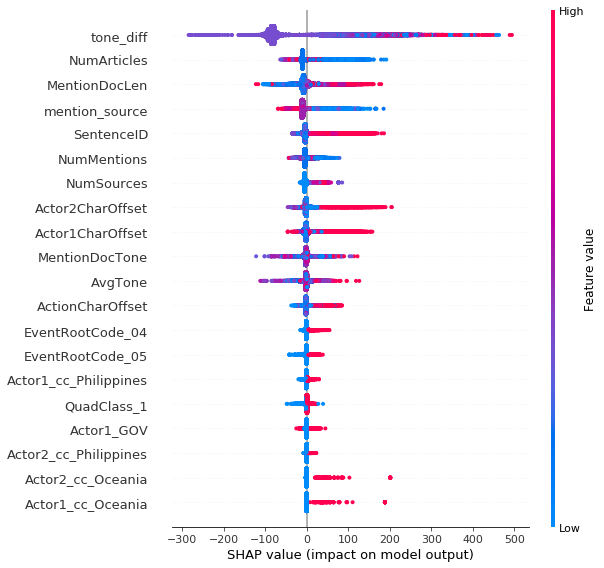

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

explainer = shap.TreeExplainer(GradientBoostingRegressor(learning_rate=0.01, max_depth=9,
                 max_features=0.5, n_estimators=350).fit(X_train, y_train))
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)